In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras_tuner as kt

In [3]:
# MNIST 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# 데이터 전처리
X_train = x_train.reshape(-1, 28, 28, 1)  # reshaping for convnet
X_test = x_test.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [5]:
# CNN 모델 정의
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                                  kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                                  activation='relu',
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

1. 하이퍼파라미터 튜닝

In [6]:
# Hyperband 튜너 설정
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='mnist')

In [7]:
# 모델 훈련
tuner.search(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

Trial 30 Complete [00h 00m 29s]
val_accuracy: 0.9835000038146973

Best val_accuracy So Far: 0.9878000020980835
Total elapsed time: 00h 08m 23s


In [8]:
# 최적의 하이퍼파라미터 및 모델 선택
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [9]:
# 최적의 모델 훈련
best_model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
469/469 [==============================] - 5s 7ms/step - loss: 1.8238 - accuracy: 0.8981 - val_loss: 0.0819 - val_accuracy: 0.9756
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1212 - accuracy: 0.9646 - val_loss: 0.0645 - val_accuracy: 0.9807
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0925 - accuracy: 0.9724 - val_loss: 0.0538 - val_accuracy: 0.9840
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0743 - accuracy: 0.9775 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0608 - accuracy: 0.9819 - val_loss: 0.0498 - val_accuracy: 0.9854


In [10]:
# 테스트 이미지 예측
test_index = np.random.randint(0, X_test.shape[0])
test_image = X_test[test_index]
true_label = np.argmax(y_test[test_index])

prediction = best_model.predict(np.expand_dims(test_image, axis=0))
predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 111ms/step


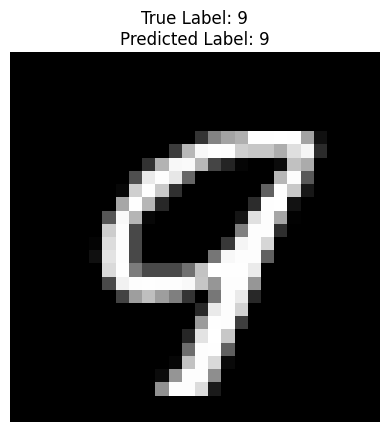

In [11]:
# 결과 출력
plt.imshow(test_image.reshape(28, 28), cmap='gray')
plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
plt.axis('off')
plt.show()

2. 모델 배포하기

In [12]:
# TensorFlow Serving을 설치
!pip install tensorflow-serving-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12

3. TFLite 모델 만들기

In [13]:
# TFLite 모델로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7d35b3fdef80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7d35b3fdef80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
# TFLite 모델 저장
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [15]:
# TFLite 모델 로드 및 서명 확인
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_model)
tflite_interpreter.allocate_tensors()

In [16]:
# 모델 정보 출력
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_conv2d_1_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
